In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Check if Cuda is available

In [3]:
num_epochs = 25
percentage_of_train_dataset = 0.20 #Out of 60K Image (To Speed up Training)
percentage_of_test_dataset = 0.20 # Out of 10K Images (To Speed up Testing)


loss_history =[]
acc_history =[]
min_loss = 9999 #To implement Simple Early Stopping
no_improvement_epoch = 0 #To implement Simple Early Stopping


https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/losses.py

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

In [5]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

indices = np.arange(len(train_dataset))
indices2 = np.arange(len(test_dataset))

train_indices, _ = train_test_split(indices, train_size=percentage_of_train_dataset, stratify=train_dataset.targets)
test_indices, _ = train_test_split(indices2, train_size=percentage_of_test_dataset, stratify=test_dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [6]:

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1152, 512)  # Corrected input size
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print(x.shape)  # Print shape for debugging
        x = x.view(-1, 1152)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
dir(model.parameters())

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [7]:
# Define ArcLoss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)


In [8]:

# Training loop

for epoch in range(num_epochs):

    model.train()
    avg_loss = 0
    loop_count = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        # print("op:", output, type(output), output.shape)
        # print("lb:", labels, type(labels), labels.shape)
        loss.backward()
        optimizer.step()
        
        loop_count +=1
        avg_loss += loss.tolist()

    avg_loss /= loop_count
    print("Avg Loss:", avg_loss)

    loss_history.append(avg_loss)


    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = model(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    acc_history.append(accuracy)


    if avg_loss < min_loss:
        min_loss = avg_loss
        # print("Model Improved")
        no_improvement_epoch = 0
    else:
        # print("No Improvement")
        no_improvement_epoch += 1
    
    if no_improvement_epoch > 10:
        print("Early Stopping, No Improvement since few Epochs")
        break


print('Training Finished')

  0%|          | 0/94 [00:00<?, ?it/s]

100%|██████████| 94/94 [00:05<00:00, 18.50it/s]


Avg Loss: 1.7916104260911332


100%|██████████| 16/16 [00:00<00:00, 50.14it/s]


Epoch [1/25], Test Accuracy: 89.40%


100%|██████████| 94/94 [00:02<00:00, 40.77it/s]


Avg Loss: 0.7991394169153051


100%|██████████| 16/16 [00:00<00:00, 48.30it/s]


Epoch [2/25], Test Accuracy: 93.70%


100%|██████████| 94/94 [00:02<00:00, 36.27it/s]


Avg Loss: 0.4330343702372084


100%|██████████| 16/16 [00:00<00:00, 47.82it/s]


Epoch [3/25], Test Accuracy: 94.85%


100%|██████████| 94/94 [00:02<00:00, 34.11it/s]


Avg Loss: 0.30906659047654333


100%|██████████| 16/16 [00:00<00:00, 48.01it/s]


Epoch [4/25], Test Accuracy: 95.95%


100%|██████████| 94/94 [00:02<00:00, 32.16it/s]


Avg Loss: 0.24169383102909048


100%|██████████| 16/16 [00:00<00:00, 47.87it/s]


Epoch [5/25], Test Accuracy: 96.60%


100%|██████████| 94/94 [00:02<00:00, 32.77it/s]


Avg Loss: 0.21270033725081605


100%|██████████| 16/16 [00:00<00:00, 45.52it/s]


Epoch [6/25], Test Accuracy: 96.85%


100%|██████████| 94/94 [00:02<00:00, 33.52it/s]


Avg Loss: 0.18195555073783753


100%|██████████| 16/16 [00:00<00:00, 45.29it/s]


Epoch [7/25], Test Accuracy: 97.05%


100%|██████████| 94/94 [00:02<00:00, 33.17it/s]


Avg Loss: 0.16321866697770485


100%|██████████| 16/16 [00:00<00:00, 47.60it/s]


Epoch [8/25], Test Accuracy: 97.45%


100%|██████████| 94/94 [00:02<00:00, 32.71it/s]


Avg Loss: 0.1485008260116298


100%|██████████| 16/16 [00:00<00:00, 47.79it/s]


Epoch [9/25], Test Accuracy: 97.75%


100%|██████████| 94/94 [00:02<00:00, 33.05it/s]


Avg Loss: 0.13652596147136487


100%|██████████| 16/16 [00:00<00:00, 47.89it/s]


Epoch [10/25], Test Accuracy: 97.65%


100%|██████████| 94/94 [00:02<00:00, 33.43it/s]


Avg Loss: 0.12447122405184076


100%|██████████| 16/16 [00:00<00:00, 47.12it/s]


Epoch [11/25], Test Accuracy: 97.70%


100%|██████████| 94/94 [00:02<00:00, 33.62it/s]


Avg Loss: 0.11344460457404877


100%|██████████| 16/16 [00:00<00:00, 47.18it/s]


Epoch [12/25], Test Accuracy: 98.05%


100%|██████████| 94/94 [00:02<00:00, 33.23it/s]


Avg Loss: 0.1140208863356012


100%|██████████| 16/16 [00:00<00:00, 48.44it/s]


Epoch [13/25], Test Accuracy: 97.90%


100%|██████████| 94/94 [00:02<00:00, 33.48it/s]


Avg Loss: 0.09707569901613479


100%|██████████| 16/16 [00:00<00:00, 48.11it/s]


Epoch [14/25], Test Accuracy: 98.20%


100%|██████████| 94/94 [00:02<00:00, 32.27it/s]


Avg Loss: 0.09532906154685832


100%|██████████| 16/16 [00:00<00:00, 46.80it/s]


Epoch [15/25], Test Accuracy: 98.15%


100%|██████████| 94/94 [00:02<00:00, 32.06it/s]


Avg Loss: 0.08394781852814745


100%|██████████| 16/16 [00:00<00:00, 45.69it/s]


Epoch [16/25], Test Accuracy: 98.30%


100%|██████████| 94/94 [00:02<00:00, 32.91it/s]


Avg Loss: 0.08488822106192721


100%|██████████| 16/16 [00:00<00:00, 47.53it/s]


Epoch [17/25], Test Accuracy: 98.50%


100%|██████████| 94/94 [00:02<00:00, 32.16it/s]


Avg Loss: 0.080639350089304


100%|██████████| 16/16 [00:00<00:00, 43.67it/s]


Epoch [18/25], Test Accuracy: 98.60%


100%|██████████| 94/94 [00:02<00:00, 32.71it/s]


Avg Loss: 0.07388664680988864


100%|██████████| 16/16 [00:00<00:00, 46.23it/s]


Epoch [19/25], Test Accuracy: 98.60%


100%|██████████| 94/94 [00:02<00:00, 33.11it/s]


Avg Loss: 0.07259669517503774


100%|██████████| 16/16 [00:00<00:00, 48.15it/s]


Epoch [20/25], Test Accuracy: 98.70%


100%|██████████| 94/94 [00:02<00:00, 32.42it/s]


Avg Loss: 0.07008122032547885


100%|██████████| 16/16 [00:00<00:00, 48.68it/s]


Epoch [21/25], Test Accuracy: 98.50%


100%|██████████| 94/94 [00:02<00:00, 34.23it/s]


Avg Loss: 0.06738352087980255


100%|██████████| 16/16 [00:00<00:00, 47.90it/s]


Epoch [22/25], Test Accuracy: 98.60%


100%|██████████| 94/94 [00:02<00:00, 35.37it/s]


Avg Loss: 0.06351711142293


100%|██████████| 16/16 [00:00<00:00, 49.22it/s]


Epoch [23/25], Test Accuracy: 98.60%


100%|██████████| 94/94 [00:02<00:00, 32.68it/s]


Avg Loss: 0.05720416702171589


100%|██████████| 16/16 [00:00<00:00, 48.33it/s]


Epoch [24/25], Test Accuracy: 98.70%


100%|██████████| 94/94 [00:02<00:00, 32.11it/s]


Avg Loss: 0.05898048415621544


100%|██████████| 16/16 [00:00<00:00, 46.18it/s]

Epoch [25/25], Test Accuracy: 98.60%
Training Finished


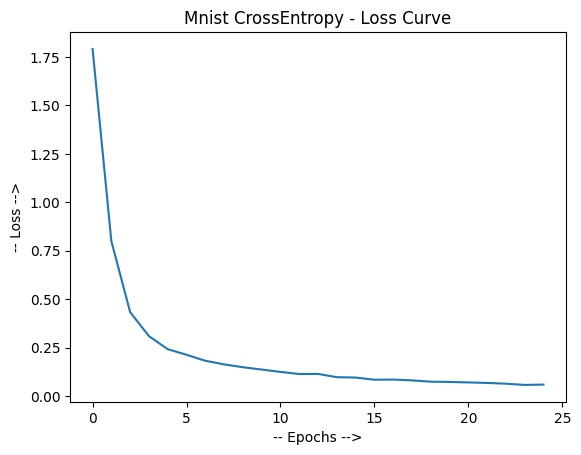

In [9]:
plt.plot(loss_history)
plt.title("Mnist CrossEntropy - Loss Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Loss -->")
plt.savefig("CrossEntropy_mnist_loss.png")
plt.show()

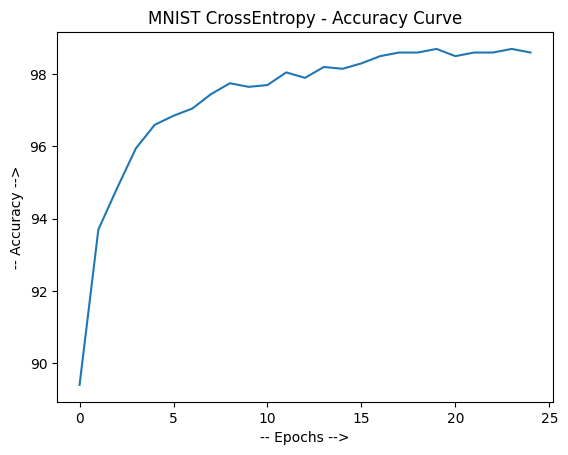

In [10]:
plt.plot(acc_history)
plt.title("MNIST CrossEntropy - Accuracy Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Accuracy -->")
plt.savefig("CrossEntropy_mnist_accuracy.png")
plt.show()

In [11]:
# Model accuracy testing
model.eval()
correct = 0
total = 0
optimizer.zero_grad()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the MNIST test set using CrossEntropy: {(100 * correct / total):.2f}%")

Testing: 100%|██████████| 16/16 [00:00<00:00, 43.86it/s]

Accuracy on the MNIST test set using CrossEntropy: 98.60%


In [12]:
# Test the Model

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        for lbl in labels.tolist():
            all_labels.append(lbl)

        for pred in predicted.tolist():
            all_predicted.append(pred)

accuracy = metrics.accuracy_score(all_labels, all_predicted)
precision = metrics.precision_score(all_labels, all_predicted, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)

100%|██████████| 16/16 [00:00<00:00, 41.52it/s]

Accuracy: 0.986
Precision: 0.986062614701889


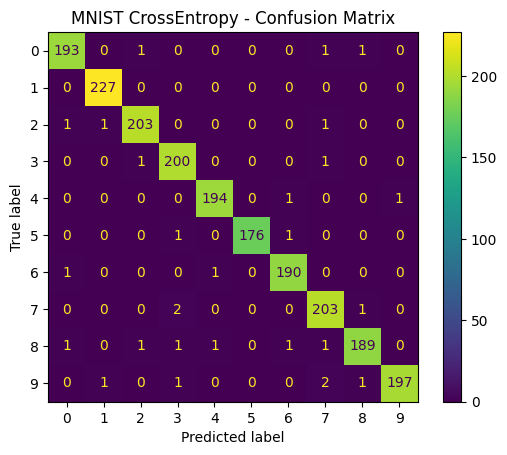

In [13]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("MNIST CrossEntropy - Confusion Matrix")
plt.savefig("CrossEntropy_mnist_cm.png")
plt.show()